In [17]:
pip install torch torchvision opencv-python streamlit


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
from google.colab import files
uploaded = files.upload()
# Upload content.jpg and style.jpg

def image_loader(img_name, max_size=400, shape=None):
    image = Image.open(img_name).convert('RGB')

    # If shape is provided, use it directly, otherwise use max_size
    if shape is not None:
        size = shape
    else:
        size = max_size if max(image.size) > max_size else max(image.size)
        size = (size, size)

    loader = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


content = image_loader("contents.jpeg")
style = image_loader("style.jpeg", shape=content.shape[-2:])


Saving contents.jpeg to contents (1).jpeg


In [20]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())


In [21]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [22]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [23]:
target = content.clone().requires_grad_(True).to(device)
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # α
style_weight = 1e6  # β

optimizer = optim.Adam([target], lr=0.003)
steps = 300

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

for step in range(steps):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total loss {total_loss.item():.4f}")


Step 0, Total loss 452033280.0000
Step 50, Total loss 263097232.0000
Step 100, Total loss 180939232.0000
Step 150, Total loss 141963024.0000
Step 200, Total loss 118606728.0000
Step 250, Total loss 102241872.0000


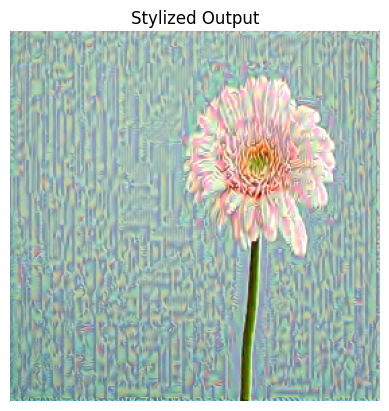

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
final_img = im_convert(target)
plt.imshow(final_img)
plt.title("Stylized Output")
plt.axis('off')
plt.show()

# Save image
output = Image.fromarray((final_img * 255).astype('uint8'))
output.save("stylized_output.jpg")
files.download("stylized_output.jpg")
